In [2]:
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

In [6]:
dataset = pd.read_csv("../../csvs/BetaFeats/sifOrbsMore=10000.0Nout=100window=10.csv", index_col = 0)
print dataset.columns.values

['runstring' 't_final_short' 'Rel_Eerr_short' 'avg_beta12' 'std_beta12'
 'min_beta12' 'max_beta12' 'avg_beta23' 'std_beta23' 'min_beta23'
 'max_beta23' 'avg_a1' 'std_a1' 'max_a1' 'min_a1' 'norm_std_a1'
 'norm_max_a1' 'norm_std_window10_a1' 'norm_max_window10_a1' 'avg_e1'
 'std_e1' 'max_e1' 'min_e1' 'norm_std_e1' 'norm_max_e1'
 'norm_std_window10_e1' 'norm_max_window10_e1' 'avg_inc1' 'std_inc1'
 'max_inc1' 'min_inc1' 'norm_std_inc1' 'norm_max_inc1'
 'norm_std_window10_inc1' 'norm_max_window10_inc1' 'avg_eH1' 'std_eH1'
 'max_eH1' 'min_eH1' 'avg_iH1' 'std_iH1' 'max_iH1' 'min_iH1' 'avg_ecross1'
 'std_ecross1' 'max_ecross1' 'min_ecross1' 'norm_a1_slope' 'avg_a2'
 'std_a2' 'max_a2' 'min_a2' 'norm_std_a2' 'norm_max_a2'
 'norm_std_window10_a2' 'norm_max_window10_a2' 'avg_e2' 'std_e2' 'max_e2'
 'min_e2' 'norm_std_e2' 'norm_max_e2' 'norm_std_window10_e2'
 'norm_max_window10_e2' 'avg_inc2' 'std_inc2' 'max_inc2' 'min_inc2'
 'norm_std_inc2' 'norm_max_inc2' 'norm_std_window10_inc2'
 'norm_max_window

In [7]:
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 
y = dataset['Stable']
X = dataset[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,norm_a2_slope,norm_a3_slope,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,max_beta23
0,0.396282,0.481704,0.000329,0.001083,0.000214,0.000456,0.000701,0.001978,0.000446,0.000964,...,2.144832e-10,2.681898e-11,8.488064,0.048209,8.344623,8.551727,15.791595,0.085995,15.576612,16.019985
1,1.034575,0.823935,0.000739,0.002137,0.000202,0.000463,0.000200,0.000350,0.000226,0.000377,...,3.559377e-11,-9.314702e-11,8.414875,0.039142,8.308582,8.495900,15.314101,0.037065,15.254833,15.368196
2,0.440470,0.491261,0.001951,0.003550,0.001735,0.002860,0.002303,0.004034,0.002080,0.003409,...,-3.330088e-11,-4.095504e-11,3.566625,0.132349,3.331239,3.773868,25.113282,0.137779,24.898424,25.351948
3,0.432098,0.550624,0.000026,0.000120,0.000005,0.000009,0.000019,0.000050,0.000016,0.000041,...,7.816527e-13,-7.257099e-12,18.513867,0.003597,18.498104,18.521611,19.142029,0.008997,19.120348,19.156777
4,5.722053,17.442426,0.028284,0.063028,0.004313,0.010716,0.038832,0.160685,0.090892,0.112168,...,3.913858e-08,-2.610208e-08,23.314674,6.756316,3.957209,38.942908,-19.036068,5.544896,-21.930247,4.156005


In [82]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
param = {'num_leaves':100, 'objective':'binary','max_depth':13,
         'learning_rate':.05,'max_bin':200, "bagging_fraction":0.95}

param['metric'] = ['auc']

best_xgb={'x_pos_weight': 6.606175001822464, 'x_learning_rate': 0.16789058169707416,
          'x_max_depth': 13, 'x_min_child': 7.0, 'x_tree_colsample': 0.7158073319959313,
          'x_subsample': 0.9872987553651339}
xgbc = XGBClassifier(seed = 0, n_estimators=100)
xgbc.param = best_xgb

In [83]:
import time
#XGB
#print score
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
start = time.time()
bst = xgb.train(best_xgb, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print score
end = time.time()
print "XGB", end - start

#LIGHTGBM
train_data = lgb.Dataset(trainX, label=trainY)
num_round=100
start=time.time()
lgbm=lgb.train(param,train_data,num_round)
ypred2=lgbm.predict(testX)
score = metrics.average_precision_score(testY, ypred2)
print score
stop=time.time()
print "LIGHT", stop - start


0.966489098431
XGB 0.529124975204
0.97687100538
LIGHT 1.37427806854


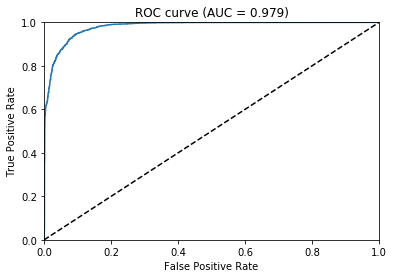

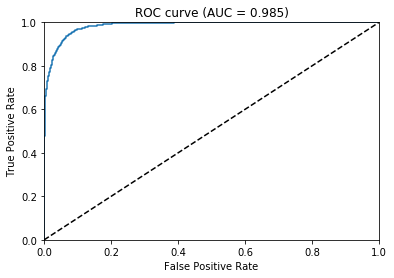

In [84]:
#the ROCAUC score is now 98.0 with the 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))


#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
fpr, tpr, thresholds = roc_curve(testY, ypred2)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, ypred2)))

In [85]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 40):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

    
print "\n\n"
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, ypred2)
for i in range(0,len(recall), 40):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))



Threshold 0.00728341937065, recall = 1.0, precision = 0.422895189003
Threshold 0.00951665639877, recall = 0.999492127984, precision = 0.430446194226
Threshold 0.0122666358948, recall = 0.999492127984, precision = 0.4440433213
Threshold 0.0144209265709, recall = 0.999492127984, precision = 0.565679793044
Threshold 0.0174534618855, recall = 0.999492127984, precision = 0.595101300272
Threshold 0.020818144083, recall = 0.998984255967, precision = 0.614303560275
Threshold 0.0247309803963, recall = 0.998984255967, precision = 0.625238397966
Threshold 0.0286546945572, recall = 0.998476383951, precision = 0.633784655061
Threshold 0.0328362286091, recall = 0.998476383951, precision = 0.643745907007
Threshold 0.0373585522175, recall = 0.998476383951, precision = 0.652722443559
Threshold 0.0435643494129, recall = 0.997968511935, precision = 0.663403106009
Threshold 0.050700455904, recall = 0.997460639919, precision = 0.673756432247
Threshold 0.0588156878948, recall = 0.996952767902, precision = 0

In [86]:
#try running both cv
d_train_cv = xgb.DMatrix(X, y)
score = xgb.cv(best_xgb, d_train_cv, nfold = 5, metrics = "auc", verbose_eval=True)
print np.mean(score)

d_train_light = lgb.Dataset(X, label = y)
score = lgb.cv(param, d_train_light, nfold=  5, metrics="auc", verbose_eval=True)


[0]	train-auc:0.972264+0.000253329	test-auc:0.963151+0.0019248
[1]	train-auc:0.97842+0.000741807	test-auc:0.968992+0.00148877
[2]	train-auc:0.981337+0.000375226	test-auc:0.97151+0.00101539
[3]	train-auc:0.983107+0.000194697	test-auc:0.972978+0.00124902
[4]	train-auc:0.984493+0.000300991	test-auc:0.97399+0.00110106
[5]	train-auc:0.985542+0.00038857	test-auc:0.974542+0.00139667
[6]	train-auc:0.986527+0.000377342	test-auc:0.974913+0.00149338
[7]	train-auc:0.987607+0.000378842	test-auc:0.975512+0.00138221
[8]	train-auc:0.988459+0.000268013	test-auc:0.975874+0.00139486
[9]	train-auc:0.98917+0.000279941	test-auc:0.976168+0.00134456
test-auc-mean     0.972763
test-auc-std      0.001379
train-auc-mean    0.983693
train-auc-std     0.000356
dtype: float64
[1]	cv_agg's auc: 0.964803 + 0.00192723
[2]	cv_agg's auc: 0.968346 + 0.00241543
[3]	cv_agg's auc: 0.970444 + 0.00182396
[4]	cv_agg's auc: 0.971232 + 0.0015626
[5]	cv_agg's auc: 0.972055 + 0.00135552
[6]	cv_agg's auc: 0.972495 + 0.0015377
[7]	c

[ 0.92506522  0.92506522  0.11392444  0.9246667   0.92502618]
1969 3031
[ 1610.   248.   141.    97.    82.    60.    67.    41.    33.    31.
    27.    38.    25.    24.    23.    17.    21.    12.     8.    19.
    18.    10.    15.    20.    18.     9.     8.    11.    17.    12.
     7.    11.     3.    11.    11.     9.    14.    14.    16.    16.
    12.    10.    20.    11.    16.    14.    12.    20.    20.    22.]
[   2    1    3    3    2    2    2    1    2    1    3    5    2    7    5
    1    2    2    1    2    1    7    3    3    2    9    8   11    8    8
    7   11   16   10    9   10   23   16   18   14   15   21   22   32   28
   36   60   97  138 1264]


(0, 350)

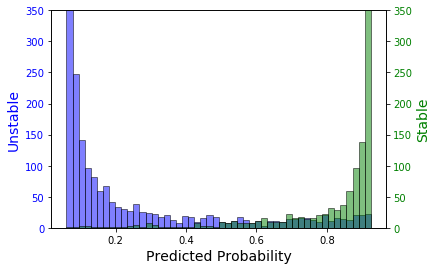

In [89]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print Stable[:5][:]
Unstable=preds[np.where(testY==0)]
print Stable.size, Unstable.size


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print n
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print n.astype(int)
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

In [90]:
importance = xgb.importance(model = bst)

AttributeError: 'module' object has no attribute 'importance'

In [109]:
gains = bst.get_score(importance_type='gain')
total_gains = np.sum(gains.values())
#print gains.keys()
#print gains.values()/total_gains*100.
#print np.sum(gains.values()/total_gains*100.)
a = {k: v / total_gains*100. for k, v in gains.iteritems()}

In [110]:
print a

{'avg_iH2': 0.97963810501501181, 'avg_iH1': 0.81447718229888089, 'std_ecross3': 1.958528465360253, 'norm_std_a3': 0.97451086285948829, 'norm_std_a2': 0.72176841274140713, 'norm_std_a1': 0.65652156381271587, 'max_beta23': 1.2888642351059547, 'std_beta12': 23.891420020762425, 'norm_std_window10_a1': 0.74565397018507007, 'norm_std_window10_a2': 0.79044247617299157, 'norm_std_window10_a3': 0.52826922906298424, 'avg_ecross3': 1.6323270991925019, 'avg_ecross2': 1.5036795135853147, 'avg_ecross1': 1.1557108089851915, 'avg_beta23': 0.61883539313626112, 'min_beta12': 1.4276587726164769, 'max_ecross1': 1.8352039262106816, 'max_ecross3': 1.7844399078685143, 'norm_max_a3': 0.69335567681281285, 'min_ecross1': 0.97919078994510822, 'norm_a3_slope': 0.70348033369519869, 'norm_a2_slope': 1.1212042743917019, 'avg_beta12': 1.2025890031466424, 'norm_max_a1': 1.0202917146698149, 'norm_max_a2': 3.315427743418399, 'std_beta23': 9.1707629861780191, 'max_beta12': 1.4134596062297353, 'max_ecross2': 27.6231014995

In [ ]:
#continue optimization from where we left off
#trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 200, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE: 0.97331414 ERROR 0.000886488656628
SCORE: 0.95724136 ERROR 0.00262090761482
SCORE: 0.97136388 ERROR 0.00116820196876
SCORE: 0.97507142 ERROR 0.000974611790626
SCORE: 0.97448168 ERROR 0.000804047904296
SCORE: 0.9746183 ERROR 0.0013837909964
SCORE: 0.97443708 ERROR 0.00106909434615
SCORE: 0.97428098 ERROR 0.00114211843062
SCORE: 0.5 ERROR 0.0
SCORE: 0.97301578 ERROR 0.00102494437422
SCORE: 0.97415178 ERROR 0.000865024171197
SCORE: 0.97422086 ERROR 0.00129155599583
SCORE: 0.97475342 ERROR 0.00111020512814
SCORE: 0.97401936 ERROR 0.000868232441742
SCORE: 0.97426986 ERROR 0.00133174242857
SCORE: 0.97331194 ERROR 0.00131697601969
SCORE: 0.9750278 ERROR 0.0012486901108
SCORE: 0.97480522 ERROR 0.00099811530029
SCORE: 0.9747807 ERROR 0.0014703158719
SCORE: 0.9741 ERROR 0.00158535028003
SCORE: 0.5 ERROR 0.0
SCORE: 0.97275844 ERROR 0.00157192825032
SCORE: 0.95226618 ERROR 0.00215073451529
SCORE: 0.93160138 ERROR 0.00451365463469
SCORE: 0.97252748 ERROR 0.00141746814872
SCORE: 0.97460502 ER

In [113]:
best

{'x_learning_rate': 0.16789058169707416,
 'x_max_depth': 13,
 'x_min_child': 7.0,
 'x_pos_weight': 6.606175001822464,
 'x_subsample': 0.9872987553651339,
 'x_tree_colsample': 0.7158073319959313}

In [115]:
#switch to the traditional 80 20 slipt, dont know why i did the 40 60 split before
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]



best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"], seed = 0)
params = best_xgbc.get_xgb_params()
#score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
#print score
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print score

0.969734432679


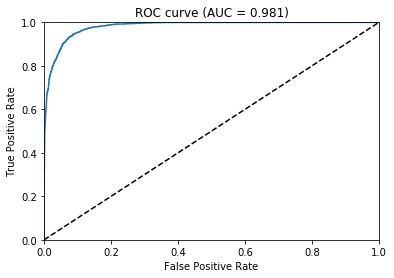

In [116]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [120]:
#continue optimization from where we left off
#trials = Trials()
#import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 200, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

('Optimization Time: %f seconds', 0.0055751800537109375)


In [140]:
print len(trials.trials)
#for i in range(200)
complete_results = [x["result"]["cv_score"] for x in trials]
print np.max(complete_results)
#print trials.trials["result"]["cv_score"]

200
0.97541326


In [141]:
#continue optimization from where we left off
#trials = Trials()
#import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 240, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE: 0.9269651 ERROR 0.00678952568796
SCORE: 0.97408176 ERROR 0.00160176232786
SCORE: 0.97511756 ERROR 0.00123192780877
SCORE: 0.5 ERROR 0.0
SCORE: 0.97485946 ERROR 0.00128539964654
SCORE: 0.9700167 ERROR 0.00137175452017
SCORE: 0.97305084 ERROR 0.00108860302281
SCORE: 0.9740227 ERROR 0.00128834768004
SCORE: 0.97479606 ERROR 0.0013248604006
SCORE: 0.96201404 ERROR 0.00155782262506
SCORE: 0.96769782 ERROR 0.00171577170606
SCORE: 0.97471986 ERROR 0.0013136699023
SCORE: 0.97434234 ERROR 0.00148134137247
SCORE: 0.9749406 ERROR 0.00116824414528
SCORE: 0.9744768 ERROR 0.000903588123843
SCORE: 0.9742705 ERROR 0.00164122840827
SCORE: 0.97510988 ERROR 0.0011779854415
SCORE: 0.97492142 ERROR 0.00148560132292
SCORE: 0.97490962 ERROR 0.00126819452943
SCORE: 0.97345802 ERROR 0.0012726414642
SCORE: 0.92626202 ERROR 0.00828981552525
SCORE: 0.97416154 ERROR 0.00146972483697
SCORE: 0.9743872 ERROR 0.001777053101
SCORE: 0.97500462 ERROR 0.00156167856715
SCORE: 0.95046256 ERROR 0.00203990513305
SCORE: 

In [142]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"], seed = 0)
params = best_xgbc.get_xgb_params()

0.969734432679


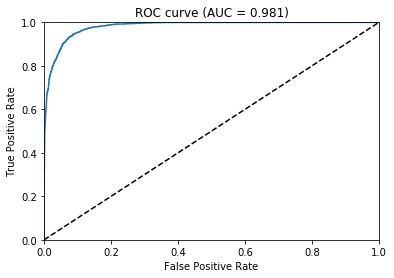

In [143]:
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print score
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [144]:
print best

{'x_pos_weight': 6.606175001822464, 'x_learning_rate': 0.16789058169707416, 'x_max_depth': 13, 'x_min_child': 7.0, 'x_tree_colsample': 0.7158073319959313, 'x_subsample': 0.9872987553651339}
